Nowe podejście - cechy wejściowe to melspectrogram - wizualna reprezentacja utworu muzycznego. Zastosowano tutaj podejście statyczne - valence i arousal jest podane jako średnia na daną piosenkę.

In [1]:
import kagglehub
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import copy
import random
import librosa
from librosa import feature

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report, confusion_matrix, accuracy_score
import seaborn as sns

In [2]:
path = kagglehub.dataset_download("imsparsh/deam-mediaeval-dataset-emotional-analysis-in-music")
print(path)
static_annotations_file = static_csv = os.path.join(path, 'DEAM_Annotations', 'annotations',
                          'annotations averaged per song', 'song_level',
                          'static_annotations_averaged_songs_1_2000.csv')
audio_path = os.path.join(path, 'DEAM_audio', 'MEMD_audio',)

C:\Users\Gabi\.cache\kagglehub\datasets\imsparsh\deam-mediaeval-dataset-emotional-analysis-in-music\versions\1


In [3]:
df = pd.read_csv(static_annotations_file)
df

,song_id,valence_mean,valence_std,arousal_mean,arousal_std
0,2,3.1,0.94,3.0,0.63
1,3,3.5,1.75,3.3,1.62
2,4,5.7,1.42,5.5,1.63
3,5,4.4,2.01,5.3,1.85
4,7,5.8,1.47,6.4,1.69
...,...,...,...,...,...
1739,1996,3.9,1.87,5.9,2.21
1740,1997,5.3,1.42,3.9,1.14
1741,1998,6.4,1.50,6.2,1.60
1742,1999,4.6,2.11,5.4,1.80


Inna skala valence i arousal - od 1 do 9. Środek układu dzielącego emocje na 4 klastry to 5.

[]

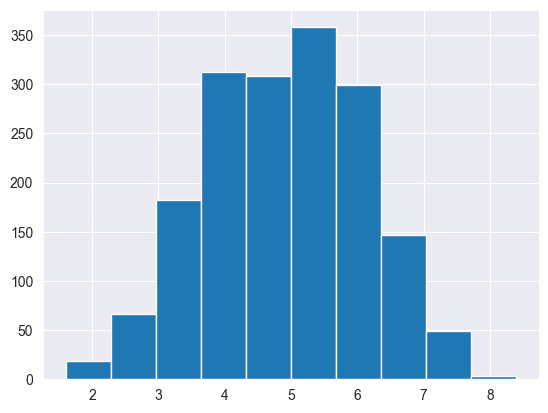

In [4]:
plt.hist(df[' valence_mean'], label='valence')
plt.plot()

[]

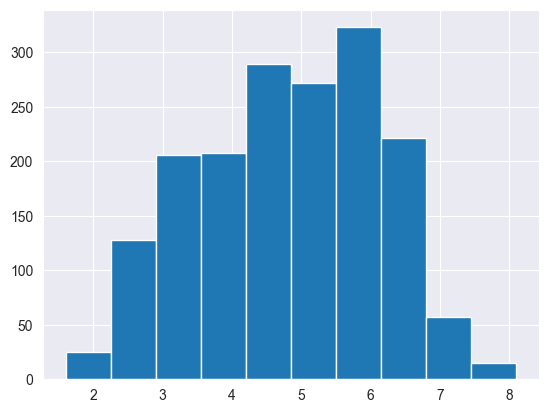

In [5]:
plt.hist(df[' arousal_mean'], label='arousal')
plt.plot()

Wizualizacja spectrogramu dla przykładowej piosenki

Audio loaded: 1987190 samples at 44100 Hz
Mel-spectrogram shape: (128, 3882)
Number of 5-second segments: 9, Shape of each: (128, 431)


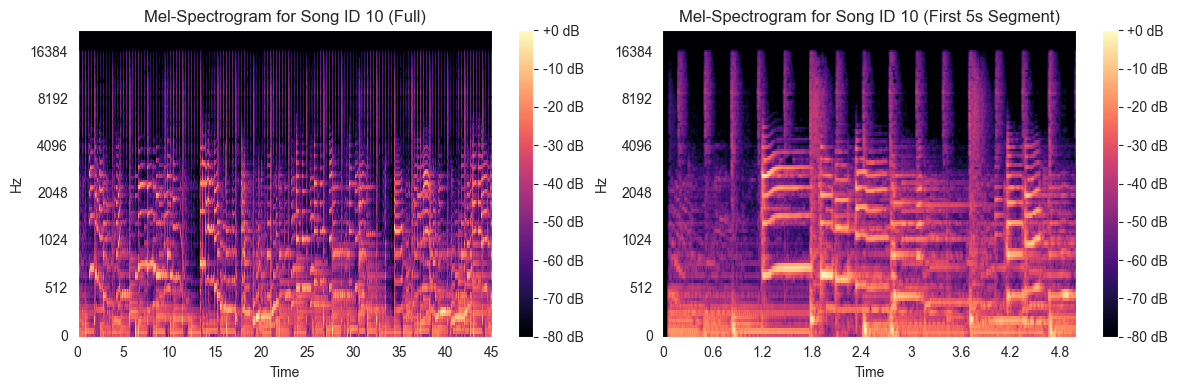

In [6]:
# !!!
file = '10.mp3'
song_id = int(file.split('.')[0])
y, sr = librosa.load(f"{audio_path}/{file}", sr=44100, mono=True)
print(f"Audio loaded: {len(y)} samples at {sr} Hz")

mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, n_fft=2048, hop_length=512)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
print(f"Mel-spectrogram shape: {mel_spec_db.shape}")
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
librosa.display.specshow(mel_spec_db, sr=sr, hop_length=512, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Mel-Spectrogram for Song ID {song_id} (Full)')
plt.tight_layout()

label = df[df['song_id'] == song_id][[' valence_mean', ' arousal_mean']].values[0]

segment_length = 5  # seconds
segment_samples = segment_length * sr
segments = [y[i : i + segment_samples] for i in range(0, len(y), segment_samples)
            if len(y[i : i + segment_samples]) == segment_samples]

mel_specs = []
for segment in segments:
    mel_spec = librosa.feature.melspectrogram(y=segment, sr=sr, n_mels=128, n_fft=2048, hop_length=512)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    mel_specs.append(mel_spec_db)

mel_specs = np.array(mel_specs)
print(f"Number of 5-second segments: {len(mel_specs)}, Shape of each: {mel_specs[0].shape}")
plt.subplot(1, 2, 2)
librosa.display.specshow(mel_specs[0], sr=sr, hop_length=512, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Mel-Spectrogram for Song ID {song_id} (First 5s Segment)')
plt.tight_layout()

Stworzenie zbioru cech oraz etykiet jako valence i arousal, piosenka dzielona na segmenty po 5 sekund. Każdy segment ma tę samą adnotację ogólną dla całej piosenki.

In [7]:
X, y = {}, {}
for song_id in df['song_id'].values:
    # !!!
    y_audio, sr = librosa.load(f"{audio_path}/{song_id}.mp3", sr=44100, mono=True)
    label = df[df['song_id'] == song_id][[' valence_mean', ' arousal_mean']].values[0]

    segment_length = 5  # seconds
    segment_samples = segment_length * sr
    segments = [y_audio[i : i + segment_samples] for i in range(0, len(y_audio), segment_samples)
                if len(y_audio[i : i + segment_samples]) == segment_samples]

    mel_specs = []
    for segment in segments:
        mel_spec = librosa.feature.melspectrogram(y=segment, sr=sr, n_mels=128, n_fft=2048, hop_length=512)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        mel_specs.append(mel_spec_db)

    X[song_id] = mel_specs
    y[song_id] = [label] * len(mel_specs)

print(X)
print(y)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



{2: [array([3.1, 3. ]), array([3.1, 3. ]), array([3.1, 3. ]), array([3.1, 3. ]), array([3.1, 3. ]), array([3.1, 3. ]), array([3.1, 3. ]), array([3.1, 3. ]), array([3.1, 3. ])], 3: [array([3.5, 3.3]), array([3.5, 3.3]), array([3.5, 3.3]), array([3.5, 3.3]), array([3.5, 3.3]), array([3.5, 3.3]), array([3.5, 3.3]), array([3.5, 3.3]), array([3.5, 3.3])], 4: [array([5.7, 5.5]), array([5.7, 5.5]), array([5.7, 5.5]), array([5.7, 5.5]), array([5.7, 5.5]), array([5.7, 5.5]), array([5.7, 5.5]), array([5.7, 5.5]), array([5.7, 5.5])], 5: [array([4.4, 5.3]), array([4.4, 5.3]), array([4.4, 5.3]), array([4.4, 5.3]), array([4.4, 5.3]), array([4.4, 5.3]), array([4.4, 5.3]), array([4.4, 5.3]), array([4.4, 5.3])], 7: [array([5.8, 6.4]), array([5.8, 6.4]), array([5.8, 6.4]), array([5.8, 6.4]), array([5.8, 6.4]), array([5.8, 6.4]), array([5.8, 6.4]), array([5.8, 6.4]), array([5.8, 6.4])], 8: [array([3.2, 4.8]), array([3.2, 4.8]), array([3.2, 4.8]), array([3.2, 4.8]), array([3.2, 4.8]), array([3.2, 4.8]), a

In [8]:
with open('../resources/X_spectrogram.pickle', 'wb') as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('../resources/y_spectrogram.pickle', 'wb') as handle:
    pickle.dump(y, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
with open('../resources/X_spectrogram.pickle', 'rb') as handle:
    X = pickle.load(handle)
with open('../resources/y_spectrogram.pickle', 'rb') as handle:
    y = pickle.load(handle)

Podział na zbiory treningowy, walidacyjny i testowy wg id piosenki - żeby uniknąć sytuacji, że testujemy dane na tej samej piosence, na której model uczyliśmy.

In [6]:
song_ids = list(X.keys())
train_ids, temp_ids = train_test_split(song_ids, test_size=0.3, random_state=42)
val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=42)

X_train, y_train, X_test, y_test, X_val, y_val = [], [], [], [], [], []
for song_id in train_ids:
    X_train.extend(X[song_id])
    y_train.extend(y[song_id])
for song_id in val_ids:
    X_val.extend(X[song_id])
    y_val.extend(y[song_id])
for song_id in test_ids:
    X_test.extend(X[song_id])
    y_test.extend(y[song_id])

X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)
X_val, y_val = np.array(X_val), np.array(y_val)

# Expand dimensions for CNN or LSTM
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

print(f"Train segments: {X_train.shape}, Val segments: {X_val.shape}, Test segments: {X_test.shape}")
print(f"Train labels: {y_train.shape}, Val labels: {y_val.shape}, Test labels: {y_test.shape}")

Train segments: (10973, 128, 431, 1), Val segments: (2357, 128, 431, 1), Test segments: (2357, 128, 431, 1)
Train labels: (10973, 2), Val labels: (2357, 2), Test labels: (2357, 2)


Skalowanie cech za pomocą MinMaxScalera

In [7]:
# Initialize MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit scaler on training labels only (flatten to 2D for scaler)
y_train_2d = y_train.reshape(-1, 2)  # Shape: (n_train_segments, 2)
y_test_2d = y_test.reshape(-1, 2)
y_val_2d = y_val.reshape(-1, 2)
scaler.fit(y_train_2d)  # Compute min and max from training set only

# Transform all sets
y_train_normalized = scaler.transform(y_train_2d).reshape(y_train.shape)
y_val_normalized = scaler.transform(y_val_2d).reshape(y_val.shape)
y_test_normalized = scaler.transform(y_test_2d).reshape(y_test.shape)

print(y_train_normalized.shape)
print(f"Training label min: {scaler.data_min_}, max: {scaler.data_max_}")
print(f"Normalized training label example: {y_train_normalized[0]}")
print(f"Normalized validation label example: {y_val_normalized[0]}")
print(f"Normalized test label example: {y_test_normalized[0]}")

(10973, 2)
Training label min: [1.6 1.8], max: [8.4 8.1]
Normalized training label example: [0.08823529 0.28571429]
Normalized validation label example: [0.51470588 0.41269841]
Normalized test label example: [0.25       0.15873016]


Przykładowy model CNN

In [71]:
# Define CNN model with Input layer
model = models.Sequential([
    layers.Input(shape=(128, 431, 1)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),

    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(2, activation='linear')  # Predicting valence and arousal
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [72]:
history = model.fit(X_train, y_train_normalized,
                    validation_data=(X_val, y_val_normalized),
                    epochs=50, batch_size=32,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10),
                               tf.keras.callbacks.ModelCheckpoint("best_cnn_model.keras", save_best_only=True)])

Epoch 1/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 189s 543ms/step - loss: 3624.9387 - mae: 9.7239 - val_loss: 0.0347 - val_mae: 0.1473
Epoch 2/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 155s 451ms/step - loss: 0.0600 - mae: 0.1965 - val_loss: 0.0329 - val_mae: 0.1437
Epoch 3/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 171s 497ms/step - loss: 0.0545 - mae: 0.1862 - val_loss: 0.0304 - val_mae: 0.1393
Epoch 4/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 176s 514ms/step - loss: 0.0497 - mae: 0.1777 - val_loss: 0.0312 - val_mae: 0.1398
Epoch 5/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 177s 515ms/step - loss: 0.0450 - mae: 0.1701 - val_loss: 0.0273 - val_mae: 0.1325
Epoch 6/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 183s 533ms/step - loss: 0.0421 - mae: 0.1637 - val_loss: 0.0294 - val_mae: 0.1362
Epoch 7/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 181s 528ms/step - loss: 0.0400 - mae: 0.1607 - val_loss: 0.0277 - val_mae: 0.1331
Epoch 8/50
343/343 ━━━━━━━━━━━━━━━━━━━━ 186s 542ms/step - loss: 0.0395 - mae: 0.1599 - val_loss: 0.0264 - val_mae: 0.1306
Epoch 9/50
343/343 ━━

In [118]:
model = tf.keras.models.load_model("best_cnn_model.keras")

In [69]:
y_pred = model.predict(X_test)
mae_valence = np.mean(np.abs(y_pred[:, 0] - y_test_normalized[:, 0]))
mae_arousal = np.mean(np.abs(y_pred[:, 1] - y_test_normalized[:, 1]))
print(f"Test MAE - Valence: {mae_valence:.4f}, Arousal: {mae_arousal:.4f}")

36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 169ms/step
Test MAE - Valence: 0.1131, Arousal: 0.1348


In [70]:
# Additional metrics
mse_valence = np.mean((y_pred[:, 0] - y_test_normalized[:, 0]) ** 2)
mse_arousal = np.mean((y_pred[:, 1] - y_test_normalized[:, 1]) ** 2)
rmse_valence = np.sqrt(mse_valence)
rmse_arousal = np.sqrt(mse_arousal)
print(f"Test MSE - Valence: {mse_valence:.4f}, Arousal: {mse_arousal:.4f}")
print(f"Test RMSE - Valence: {rmse_valence:.4f}, Arousal: {rmse_arousal:.4f}")

Test MSE - Valence: 0.0200, Arousal: 0.0280
Test RMSE - Valence: 0.1414, Arousal: 0.1672


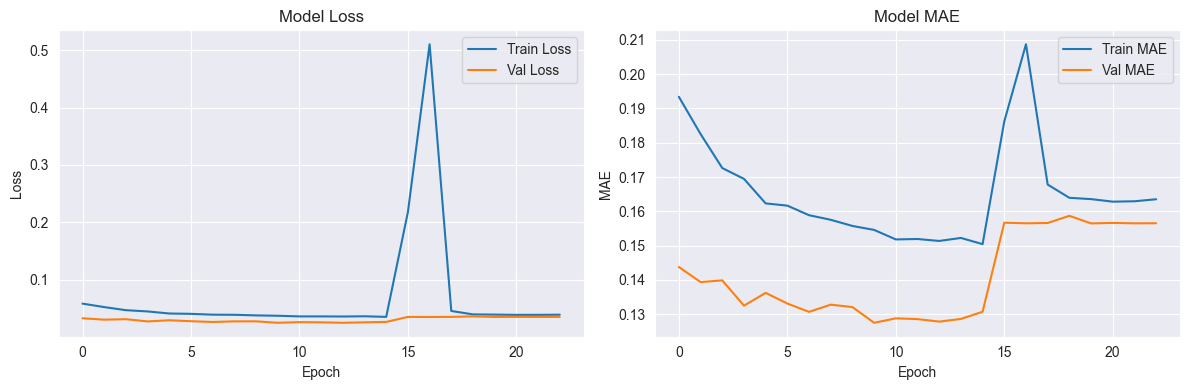

In [77]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'][1:], label='Train Loss')
plt.plot(history.history['val_loss'][1:], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'][1:], label='Train MAE')
plt.plot(history.history['val_mae'][1:], label='Val MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [71]:
# Evaluate song_id=47 specifically
specific_song_id = 47
idx_start = sum(len(X[sid]) for sid in test_ids[:test_ids.index(specific_song_id)])
idx_end = idx_start + len(X[specific_song_id])

y_pred_song47 = y_pred[idx_start:idx_end]
y_true_song47 = y_test_normalized[idx_start:idx_end]

pred_original = scaler.inverse_transform([np.mean(y_pred_song47, axis=0)])[0]
true_original = scaler.inverse_transform([np.mean(y_true_song47, axis=0)])[0]
print(f"Predicted (Original): Valence {pred_original[0]:.1f}, Arousal {pred_original[1]:.1f}")
print(f"True (Original): Valence {true_original[0]:.1f}, Arousal {true_original[1]:.1f}")

Predicted (Original): Valence 5.1, Arousal 4.9
True (Original): Valence 4.4, Arousal 4.4


In [38]:
def classify_emotion(valence, arousal):
    if valence >= 5 and arousal >= 5:
        return 'happy'
    if valence >= 5 and arousal < 5:
        return 'relaxed'
    if valence <= 5 and arousal <= 5:
        return 'sad'
    if valence <= 5 and arousal >= 5:
        return 'anger'
    # return 'indifferent'

In [39]:
def evaluate_model(y_test, y_pred, probe_number=3):
    mse_valence = mean_squared_error(y_pred[:, 0], y_test[:, 0])
    mse_arousal = mean_squared_error(y_pred[:, 1], y_test[:, 1])
    print("REGRESSION ERRORS")
    print("-------------------------------------")
    print(f"MSE Valence: {mse_valence:.4f}")
    print(f"MSE Arousal: {mse_arousal:.4f}")
    print("-------------------------------------")

    mae_valence = mean_absolute_error(y_pred[:, 0], y_test[:, 0])
    mae_arousal = mean_absolute_error(y_pred[:, 1], y_test[:, 1])
    print(f"MAE Valence: {mae_valence:.4f}")
    print(f"MAE Arousal: {mae_arousal:.4f}")
    print("-------------------------------------")

    r2_valence = r2_score(y_pred[:, 0], y_test[:, 0])
    r2_arousal = r2_score(y_pred[:, 1], y_test[:, 1])
    print(f"R² Valence: {r2_valence:.4f}")
    print(f"R² Arousal: {r2_arousal:.4f}")
    print("-------------------------------------")

    print("CLASSIFICATION ACCURACY\n")

    classification_pred = []
    classification_true = []
    for i in range(len(y_test)):
        pred = scaler.inverse_transform([y_pred[i]])[0]
        valence_pred = pred[0]
        arousal_pred = pred[1]

        test = scaler.inverse_transform([y_test[i]])[0]
        valence_test = test[0]
        arousal_test = test[1]

        classification_pred.append(classify_emotion(valence_pred, arousal_pred))
        classification_true.append(classify_emotion(valence_test, arousal_test))

    print("Accuracy:", accuracy_score(classification_true, classification_pred))
    print(classification_report(classification_true, classification_pred))
    conusion_matrix = confusion_matrix(classification_true, classification_pred)

    ax = plt.subplot()
    sns.heatmap(conusion_matrix, annot=True, cmap='Blues')
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(np.unique(classification_true))
    ax.yaxis.set_ticklabels(np.unique(classification_true))

Biorąc pod uwagę zmianę skali dla przewidywanych wartości, błędy regresji są bardzo podobne. Przy klasyfikacji dominująca tym razem stała się klasa sad.

REGRESSION ERRORS
-------------------------------------
MSE Valence: 0.0172
MSE Arousal: 0.0239
-------------------------------------
MAE Valence: 0.1057
MAE Arousal: 0.1255
-------------------------------------
R² Valence: -0.6933
R² Arousal: -1.4983
-------------------------------------
CLASSIFICATION ACCURACY

Accuracy: 0.6376554174067496
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00       133
       happy       0.37      0.65      0.47       160
     relaxed       0.12      0.02      0.03       159
         sad       0.75      0.91      0.82       674

    accuracy                           0.64      1126
   macro avg       0.31      0.39      0.33      1126
weighted avg       0.52      0.64      0.56      1126



C:\Users\Gabi\PycharmProjects\Music-Emotion-Recognition\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Gabi\PycharmProjects\Music-Emotion-Recognition\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Gabi\PycharmProjects\Music-Emotion-Recognition\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

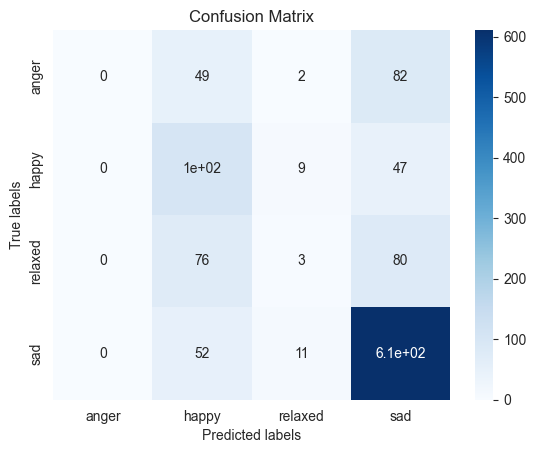

In [120]:
evaluate_model(y_test_normalized, y_pred)

Sprawdzenie, czy przy klasyfikacji pomoże dodanie klasy emocji neutral - ponieważ wartości blisko środka układu współrzędnych (5, 5) różnią się od siebie w niewielkim stopniu, a teoretycznie mogą wskazywać na bardzo skrajne emocje. Jednak na ten moment piąta emocja jeszcze bardziej zmniejsza czytelność modelu - neutralnych wartości nie ma aż tak dużo.

In [40]:
def classify_emotion_5(valence, arousal):
    if 4.5 <= valence <= 5.5 and 4.5 <= arousal <= 5.5:
        return 'neutral'
    if valence >= 5 and arousal >= 5:
        return 'happy'
    if valence >= 5 and arousal < 5:
        return 'relaxed'
    if valence <= 5 and arousal <= 5:
        return 'sad'
    if valence <= 5 and arousal >= 5:
        return 'anger'
    return 'indifferent'


def evaluate_model_5(y_test, y_pred, probe_number=3):
    mse_valence = mean_squared_error(y_pred[:, 0], y_test[:, 0])
    mse_arousal = mean_squared_error(y_pred[:, 1], y_test[:, 1])
    print("REGRESSION ERRORS")
    print("-------------------------------------")
    print(f"MSE Valence: {mse_valence:.4f}")
    print(f"MSE Arousal: {mse_arousal:.4f}")
    print("-------------------------------------")

    mae_valence = mean_absolute_error(y_pred[:, 0], y_test[:, 0])
    mae_arousal = mean_absolute_error(y_pred[:, 1], y_test[:, 1])
    print(f"MAE Valence: {mae_valence:.4f}")
    print(f"MAE Arousal: {mae_arousal:.4f}")
    print("-------------------------------------")

    r2_valence = r2_score(y_pred[:, 0], y_test[:, 0])
    r2_arousal = r2_score(y_pred[:, 1], y_test[:, 1])
    print(f"R² Valence: {r2_valence:.4f}")
    print(f"R² Arousal: {r2_arousal:.4f}")
    print("-------------------------------------")

    print("CLASSIFICATION ACCURACY\n")

    classification_pred = []
    classification_true = []
    for i in range(len(y_test)):
        pred = scaler.inverse_transform([y_pred[i]])[0]
        valence_pred = pred[0]
        arousal_pred = pred[1]

        test = scaler.inverse_transform([y_test[i]])[0]
        valence_test = test[0]
        arousal_test = test[1]

        classification_pred.append(classify_emotion_5(valence_pred, arousal_pred))
        classification_true.append(classify_emotion_5(valence_test, arousal_test))

    print("Accuracy:", accuracy_score(classification_true, classification_pred))
    print(classification_report(classification_true, classification_pred))
    conusion_matrix = confusion_matrix(classification_true, classification_pred)

    ax = plt.subplot()
    sns.heatmap(conusion_matrix, annot=True, cmap='Blues')
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(np.unique(classification_true))
    ax.yaxis.set_ticklabels(np.unique(classification_true))

REGRESSION ERRORS
-------------------------------------
MSE Valence: 0.0172
MSE Arousal: 0.0239
-------------------------------------
MAE Valence: 0.1057
MAE Arousal: 0.1255
-------------------------------------
R² Valence: -0.6933
R² Arousal: -1.4983
-------------------------------------
CLASSIFICATION ACCURACY

Accuracy: 0.4928952042628774
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00       119
       happy       0.36      0.26      0.31       136
     neutral       0.11      0.66      0.19        76
     relaxed       0.00      0.00      0.00       149
         sad       0.82      0.73      0.77       646

    accuracy                           0.49      1126
   macro avg       0.26      0.33      0.25      1126
weighted avg       0.52      0.49      0.49      1126



C:\Users\Gabi\PycharmProjects\Music-Emotion-Recognition\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Gabi\PycharmProjects\Music-Emotion-Recognition\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Gabi\PycharmProjects\Music-Emotion-Recognition\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

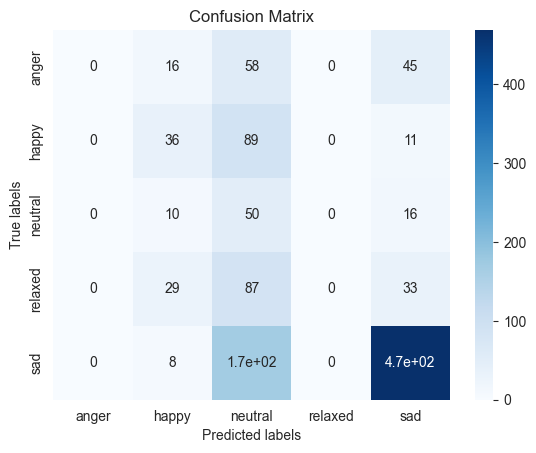

In [121]:
evaluate_model_5(y_test_normalized, y_pred)

Ograniczenie ilości piosenek radosnych

In [10]:
conditions = [
    (df[' valence_mean'] >= 5) & (df[' arousal_mean'] >= 5),
    (df[' valence_mean'] >= 5) & (df[' arousal_mean'] <= 5),
    (df[' valence_mean'] <= 5) & (df[' arousal_mean'] <= 5),
    (df[' valence_mean'] <= 5) & (df[' arousal_mean'] >= 5)
]
choices = ['happy', 'relaxed', 'sad', 'anger']
df_4 = df.copy(deep=True)
df_4['emotion'] = np.select(conditions, choices, default=None)
first = df_4.pop('emotion')
df_4.insert(4, 'emotion', first)
df_4

,song_id,valence_mean,valence_std,arousal_mean,emotion,arousal_std
0,2,3.1,0.94,3.0,sad,0.63
1,3,3.5,1.75,3.3,sad,1.62
2,4,5.7,1.42,5.5,happy,1.63
3,5,4.4,2.01,5.3,anger,1.85
4,7,5.8,1.47,6.4,happy,1.69
...,...,...,...,...,...,...
1739,1996,3.9,1.87,5.9,anger,2.21
1740,1997,5.3,1.42,3.9,relaxed,1.14
1741,1998,6.4,1.50,6.2,happy,1.60
1742,1999,4.6,2.11,5.4,anger,1.80


emotion
sad        696
happy      634
relaxed    222
anger      192
Name: count, dtype: int64


[]

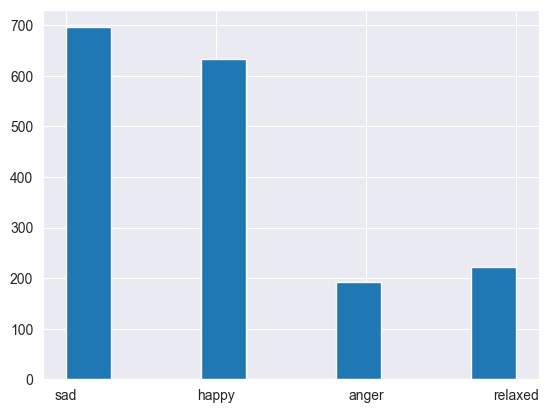

In [45]:
print(df_4['emotion'].value_counts())
plt.hist(df_4['emotion'])
plt.plot()

In [12]:
conditions = [
    (4.5 <= df[' valence_mean']) & (df[' valence_mean'] <= 5.5) & (4.5 <= df[' arousal_mean']) & (df[' arousal_mean'] <= 5.5),
    (df[' valence_mean'] >= 5) & (df[' arousal_mean'] >= 5),
    (df[' valence_mean'] >= 5) & (df[' arousal_mean'] <= 5),
    (df[' valence_mean'] <= 5) & (df[' arousal_mean'] <= 5),
    (df[' valence_mean'] <= 5) & (df[' arousal_mean'] >= 5)
]
choices = ['neutral', 'happy', 'relaxed', 'sad', 'anger']
df_5 = df.copy(deep=True)
df_5['emotion'] = np.select(conditions, choices, default=None)
first = df_5.pop('emotion')
df_5.insert(4, 'emotion', first)
df_5

,song_id,valence_mean,valence_std,arousal_mean,emotion,arousal_std
0,2,3.1,0.94,3.0,sad,0.63
1,3,3.5,1.75,3.3,sad,1.62
2,4,5.7,1.42,5.5,happy,1.63
3,5,4.4,2.01,5.3,anger,1.85
4,7,5.8,1.47,6.4,happy,1.69
...,...,...,...,...,...,...
1739,1996,3.9,1.87,5.9,anger,2.21
1740,1997,5.3,1.42,3.9,relaxed,1.14
1741,1998,6.4,1.50,6.2,happy,1.60
1742,1999,4.6,2.11,5.4,neutral,1.80


emotion
sad        638
happy      558
neutral    204
relaxed    186
anger      158
Name: count, dtype: int64


[]

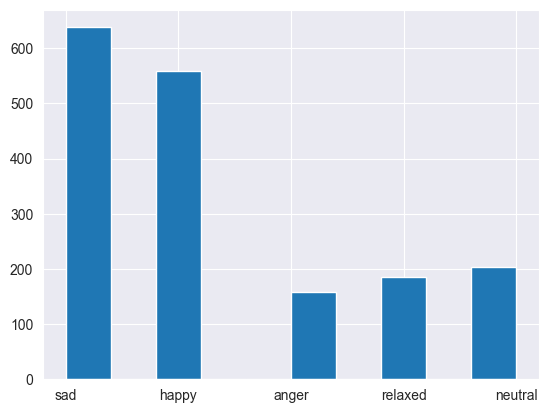

In [46]:
print(df_5['emotion'].value_counts())

plt.hist(df_5['emotion'])
plt.plot()

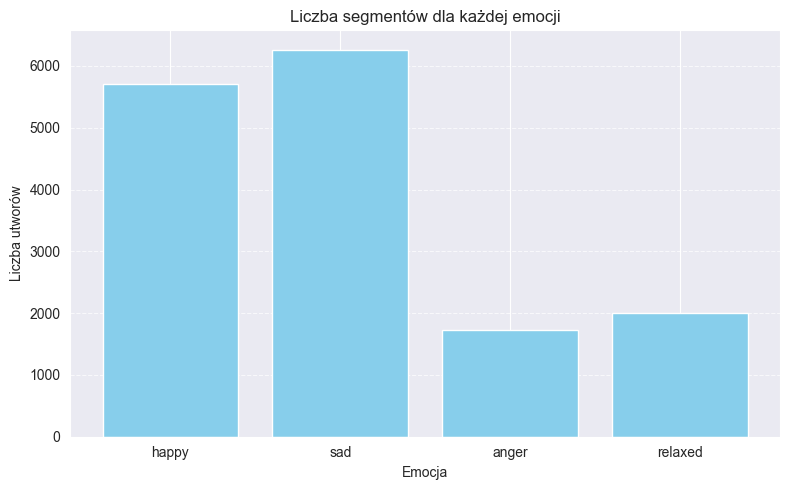

In [15]:
X_4_emotions = copy.deepcopy(X)
y_4_emotions = copy.deepcopy(y)

song_ids = list(X_4_emotions.keys())
emotion_amount = {
    'happy': 0,
    'sad': 0,
    'anger': 0,
    'relaxed': 0
}
for song_id in song_ids:
    segment_number = len(X_4_emotions[song_id])
    emotion = df_4[df_4['song_id'] == song_id]['emotion'].iloc[0]
    if emotion == 'happy':
        emotion_amount['happy'] += segment_number
    elif emotion == 'sad':
        emotion_amount['sad'] += segment_number
    elif emotion == 'anger':
        emotion_amount['anger'] += segment_number
    elif emotion == 'relaxed':
        emotion_amount['relaxed'] += segment_number

labels = list(emotion_amount.keys())
values = list(emotion_amount.values())

plt.figure(figsize=(8, 5))
plt.bar(labels, values, color='skyblue')
plt.title('Liczba segmentów dla każdej emocji')
plt.xlabel('Emocja')
plt.ylabel('Liczba utworów')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [18]:
song_ids = list(X_4_emotions.keys())
for song_id in song_ids:
    segment_number = len(X_4_emotions[song_id])
    emotion = df_4[df_4['song_id'] == song_id]['emotion'].iloc[0]
    if emotion == 'happy' or emotion == 'sad':
        num_to_remove = int(segment_number * 0.7)
        # print(segment_number, num_to_remove)
    else:
        continue

    indices_to_remove = sorted(random.sample(range(len(X_4_emotions[song_id])), num_to_remove), reverse=True)
    for idx in indices_to_remove:
        del X_4_emotions[song_id][idx]
        if song_id in y_4_emotions:
            del y_4_emotions[song_id][idx]

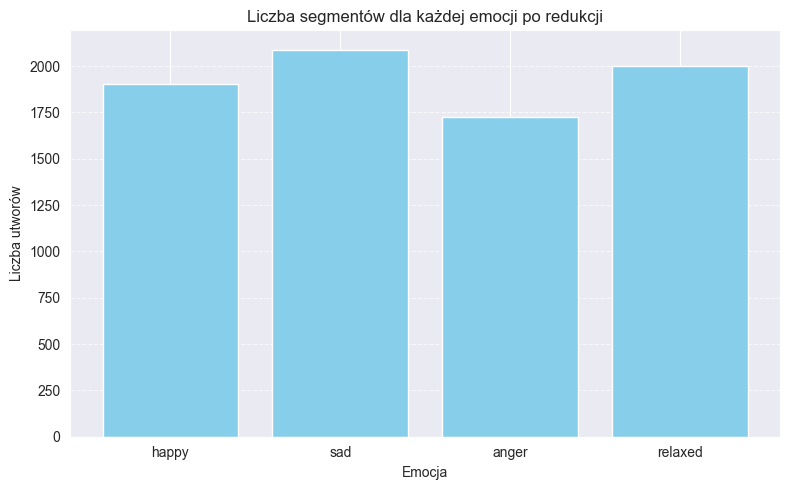

In [23]:
song_ids = list(X_4_emotions.keys())
emotion_amount = {
    'happy': 0,
    'sad': 0,
    'anger': 0,
    'relaxed': 0
}
for song_id in song_ids:
    segment_number = len(X_4_emotions[song_id])
    emotion = df_4[df_4['song_id'] == song_id]['emotion'].iloc[0]
    if emotion == 'happy':
        emotion_amount['happy'] += segment_number
    elif emotion == 'sad':
        emotion_amount['sad'] += segment_number
    elif emotion == 'anger':
        emotion_amount['anger'] += segment_number
    elif emotion == 'relaxed':
        emotion_amount['relaxed'] += segment_number

labels = list(emotion_amount.keys())
values = list(emotion_amount.values())

plt.figure(figsize=(8, 5))
plt.bar(labels, values, color='skyblue')
plt.title('Liczba segmentów dla każdej emocji po redukcji')
plt.xlabel('Emocja')
plt.ylabel('Liczba utworów')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

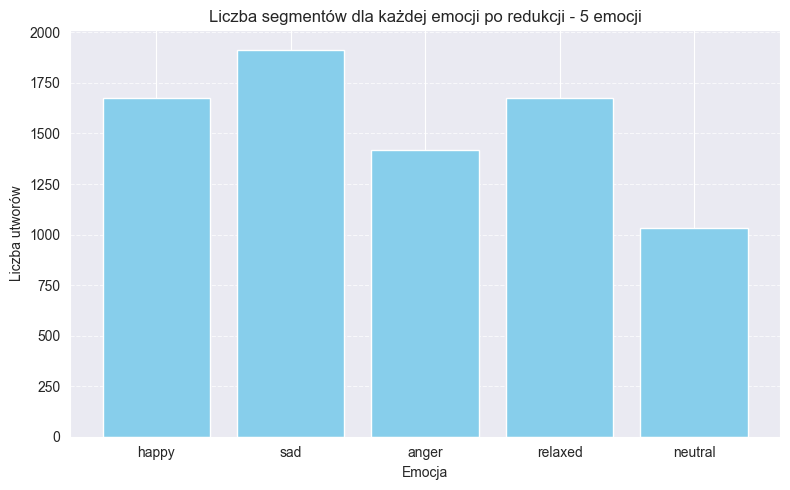

In [41]:
song_ids = list(X_4_emotions.keys())
emotion_amount = {
    'happy': 0,
    'sad': 0,
    'anger': 0,
    'relaxed': 0,
    'neutral': 0
}
for song_id in song_ids:
    segment_number = len(X_4_emotions[song_id])
    emotion = df_5[df_5['song_id'] == song_id]['emotion'].iloc[0]
    if emotion == 'happy':
        emotion_amount['happy'] += segment_number
    elif emotion == 'sad':
        emotion_amount['sad'] += segment_number
    elif emotion == 'anger':
        emotion_amount['anger'] += segment_number
    elif emotion == 'relaxed':
        emotion_amount['relaxed'] += segment_number
    elif emotion == 'neutral':
        emotion_amount['neutral'] += segment_number

labels = list(emotion_amount.keys())
values = list(emotion_amount.values())

plt.figure(figsize=(8, 5))
plt.bar(labels, values, color='skyblue')
plt.title('Liczba segmentów dla każdej emocji po redukcji - 5 emocji')
plt.xlabel('Emocja')
plt.ylabel('Liczba utworów')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [26]:
train_ids, temp_ids = train_test_split(song_ids, test_size=0.3, random_state=42)
val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=42)

X_train_4, y_train_4, X_test_4, y_test_4, X_val_4, y_val_4 = [], [], [], [], [], []
for song_id in train_ids:
    X_train_4.extend(X_4_emotions[song_id])
    y_train_4.extend(y_4_emotions[song_id])
for song_id in val_ids:
    X_val_4.extend(X_4_emotions[song_id])
    y_val_4.extend(y_4_emotions[song_id])
for song_id in test_ids:
    X_test_4.extend(X_4_emotions[song_id])
    y_test_4.extend(y_4_emotions[song_id])

X_train_4, y_train_4 = np.array(X_train_4), np.array(y_train_4)
X_test_4, y_test_4 = np.array(X_test_4), np.array(y_test_4)
X_val_4, y_val_4 = np.array(X_val_4), np.array(y_val_4)

# Expand dimensions for CNN or LSTM
X_train_4 = np.expand_dims(X_train_4, axis=-1)
X_val_4 = np.expand_dims(X_val_4, axis=-1)
X_test_4 = np.expand_dims(X_test_4, axis=-1)

print(f"Train segments: {X_train_4.shape}, Val segments: {X_val_4.shape}, Test segments: {X_test_4.shape}")
print(f"Train labels: {y_train_4.shape}, Val labels: {y_val_4.shape}, Test labels: {y_test_4.shape}")

Train segments: (5404, 128, 431, 1), Val segments: (1193, 128, 431, 1), Test segments: (1116, 128, 431, 1)
Train labels: (5404, 2), Val labels: (1193, 2), Test labels: (1116, 2)


In [29]:
# Initialize MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit scaler on training labels only (flatten to 2D for scaler)
y_train_2d_4 = y_train_4.reshape(-1, 2)  # Shape: (n_train_segments, 2)
y_test_2d_4 = y_test_4.reshape(-1, 2)
y_val_2d_4 = y_val_4.reshape(-1, 2)
scaler.fit(y_train_2d_4)  # Compute min and max from training set only

# Transform all sets
y_train_normalized_4 = scaler.transform(y_train_2d_4).reshape(y_train_4.shape)
y_val_normalized_4 = scaler.transform(y_val_2d_4).reshape(y_val_4.shape)
y_test_normalized_4 = scaler.transform(y_test_2d_4).reshape(y_test_4.shape)

print(y_train_normalized_4.shape)
print(f"Training label min: {scaler.data_min_}, max: {scaler.data_max_}")
print(f"Normalized training label example: {y_train_normalized_4[0]}")
print(f"Normalized validation label example: {y_val_normalized_4[0]}")
print(f"Normalized test label example: {y_test_normalized_4[0]}")

(5404, 2)
Training label min: [1.6 1.8], max: [8.4 8.1]
Normalized training label example: [0.08823529 0.28571429]
Normalized validation label example: [0.51470588 0.41269841]
Normalized test label example: [0.25       0.15873016]


Sieć CNN dla wyrównanego zbioru, który przewiduje 4 emocje

In [31]:
# Define CNN model with Input layer
model_4 = models.Sequential([
    layers.Input(shape=(128, 431, 1)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),

    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(2, activation='linear')  # Predicting valence and arousal
])

model_4.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [32]:
history_4 = model_4.fit(X_train_4, y_train_normalized_4,
                    validation_data=(X_val_4, y_val_normalized_4),
                    epochs=50, batch_size=32,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10),
                               tf.keras.callbacks.ModelCheckpoint("best_cnn_model_4.keras", save_best_only=True)])

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 118s 686ms/step - loss: 13522.1455 - mae: 21.8337 - val_loss: 0.0691 - val_mae: 0.2174
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 92s 546ms/step - loss: 0.1171 - mae: 0.2775 - val_loss: 0.0677 - val_mae: 0.2127
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 94s 557ms/step - loss: 0.1118 - mae: 0.2700 - val_loss: 0.0556 - val_mae: 0.1900
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 93s 554ms/step - loss: 0.1116 - mae: 0.2692 - val_loss: 0.0448 - val_mae: 0.1689
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 93s 548ms/step - loss: 0.1113 - mae: 0.2684 - val_loss: 0.0585 - val_mae: 0.1963
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 110s 651ms/step - loss: 0.0986 - mae: 0.2520 - val_loss: 0.0299 - val_mae: 0.1390
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 108s 639ms/step - loss: 0.0762 - mae: 0.2212 - val_loss: 0.0309 - val_mae: 0.1406
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 94s 555ms/step - loss: 0.0774 - mae: 0.2230 - val_loss: 0.0407 - val_mae: 0.1624
Epoch 9/50
169/169 ━━━━━

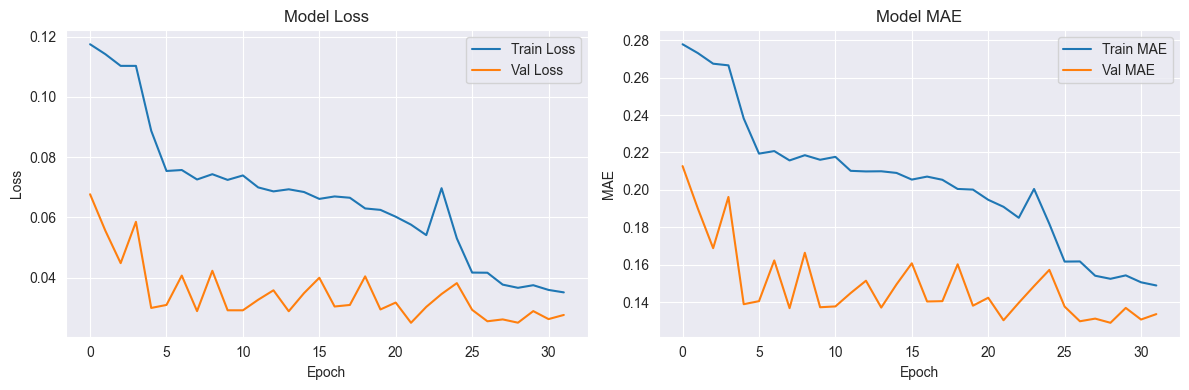

In [37]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_4.history['loss'][1:], label='Train Loss')
plt.plot(history_4.history['val_loss'][1:], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_4.history['mae'][1:], label='Train MAE')
plt.plot(history_4.history['val_mae'][1:], label='Val MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [34]:
model_4 = tf.keras.models.load_model("best_cnn_model_4.keras")

In [35]:
y_pred_4 = model_4.predict(X_test_4)
mae_valence = np.mean(np.abs(y_pred_4[:, 0] - y_test_normalized_4[:, 0]))
mae_arousal = np.mean(np.abs(y_pred_4[:, 1] - y_test_normalized_4[:, 1]))
print(f"Test MAE - Valence: {mae_valence:.4f}, Arousal: {mae_arousal:.4f}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step
Test MAE - Valence: 0.1091, Arousal: 0.1295


Krzywe uczenia wyglądają bardziej naturalnie niż wcześniej, a macierz konfuzji jest odrobinę bardziej zrównoważona - nie ma jednej dominującej klasy.

REGRESSION ERRORS
-------------------------------------
MSE Valence: 0.0186
MSE Arousal: 0.0254
-------------------------------------
MAE Valence: 0.1091
MAE Arousal: 0.1295
-------------------------------------
R² Valence: -3.6362
R² Arousal: -2.2134
-------------------------------------
CLASSIFICATION ACCURACY

Accuracy: 0.4596774193548387
              precision    recall  f1-score   support

       anger       0.40      0.01      0.02       252
       happy       0.40      0.68      0.51       240
     relaxed       0.27      0.23      0.25       243
         sad       0.59      0.76      0.67       381

    accuracy                           0.46      1116
   macro avg       0.41      0.42      0.36      1116
weighted avg       0.44      0.46      0.39      1116



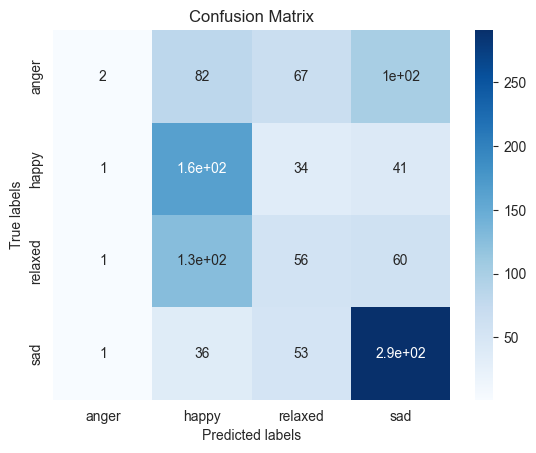

In [42]:
evaluate_model(y_test_normalized_4, y_pred_4)

Podział na 5 emocji przynosi gorsze rezultaty.

REGRESSION ERRORS
-------------------------------------
MSE Valence: 0.0186
MSE Arousal: 0.0254
-------------------------------------
MAE Valence: 0.1091
MAE Arousal: 0.1295
-------------------------------------
R² Valence: -3.6362
R² Arousal: -2.2134
-------------------------------------
CLASSIFICATION ACCURACY

Accuracy: 0.37992831541218636
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00       189
       happy       0.45      0.29      0.36       204
     neutral       0.21      0.70      0.33       186
     relaxed       0.00      0.00      0.00       198
         sad       0.63      0.69      0.66       339

    accuracy                           0.38      1116
   macro avg       0.26      0.34      0.27      1116
weighted avg       0.31      0.38      0.32      1116



C:\Users\Gabi\PycharmProjects\Music-Emotion-Recognition\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Gabi\PycharmProjects\Music-Emotion-Recognition\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Gabi\PycharmProjects\Music-Emotion-Recognition\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

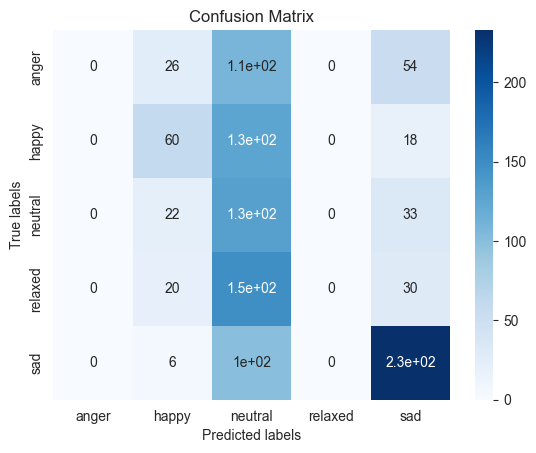

In [43]:
evaluate_model_5(y_test_normalized_4, y_pred_4)